In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import glob, os

%matplotlib inline

# Writing a file


In [4]:
sample_label = "/Users/dutking/LOCAL/AI_uni/radlogix/dataset/labels/LUNG1-001/LUNG1-001_effusion_first_reviewer.nii.gz"
sample_feature = "/Users/dutking/LOCAL/AI_uni/radlogix/dataset/features/LUNG1-001/09-18-2008-StudyID-NA-69331/0.000000-NA-82046"

In [5]:
def plot_slice(image_array):
    middle_slice_num = int(image_array.shape[0] / 2)
    middle_slice_array = image_array[middle_slice_num, :, :, :]
    plt.title(f"slice {middle_slice_num}")
    plt.imshow(
        middle_slice_array,
        cmap=plt.cm.Greys_r,
        vmin=image_array.min(),
        vmax=image_array.max(),
    )
    plt.show()

In [6]:
def plot_overlay(feature, label):
    mid_slice = int(feature.shape[0] / 2)
    feature_slice = feature[mid_slice, :, :, :]
    label_slice = np.squeeze(label[mid_slice, :, :, :])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax[0].imshow(feature_slice, cmap="bone", interpolation="none")
    ax[1].imshow(feature_slice, cmap="bone", interpolation="none")
    ax[1].imshow(label_slice, cmap="prism", vmin=0, vmax=1, alpha=0.5 * (label_slice))
    plt.show()

feature data type: int16
feature shape: [134 512 512   1]
feature shape dtype: int64


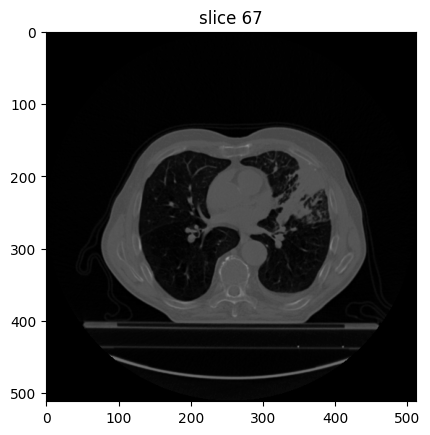

In [8]:
def get_feature(dicom_folder):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_folder)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image = sitk.DICOMOrient(image, "LPS")
    image_array = sitk.GetArrayFromImage(image)
    image_array_shape = image_array.shape
    image_array = image_array.reshape(
        (image_array_shape[0], image_array_shape[1], image_array_shape[2], 1)
    ).astype(dtype=np.int16)
    image_array_dtype = image_array.dtype
    image_array_shape = np.array(image_array.shape)
    return image_array.astype(dtype=np.int16), image_array_dtype, image_array_shape


my_feature, my_feature_dtype, my_feature_shape = get_feature(sample_feature)

print("feature data type:", my_feature_dtype)
print("feature shape:", my_feature_shape)
print("feature shape dtype:", my_feature_shape.dtype)
plot_slice(my_feature)

label data type: int16
label shape: [134 512 512   1]


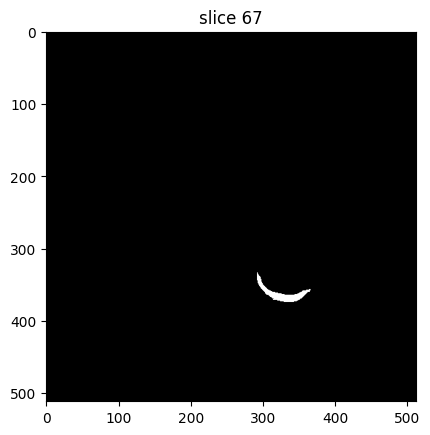

In [9]:
def get_label(file):
    image = sitk.ReadImage(file)
    image = sitk.DICOMOrient(image, "LPS")
    image_array = sitk.GetArrayFromImage(image)
    image_array_dtype = image_array.dtype
    image_array_shape = image_array.shape
    image_array = image_array.reshape(
        (image_array_shape[0], image_array_shape[1], image_array_shape[2], 1)
    ).astype(dtype=np.int16)
    image_array_dtype = image_array.dtype
    image_array_shape = np.array(image_array.shape)
    return image_array.astype(dtype=np.int16), image_array_dtype, image_array_shape


my_label, my_label_dtype, my_label_shape = get_label(sample_label)

print("label data type:", my_label_dtype)
print("label shape:", my_label_shape)
plot_slice(my_label)

In [28]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [29]:
# Create the features dictionary.
def image_example(feature, label, shape):
    feature = {
        "shape": _bytes_feature(shape.tobytes()),
        "label": _bytes_feature(label.tobytes()),
        "feature": _bytes_feature(feature.tobytes()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


tf_example = image_example(my_feature, my_label, my_feature_shape)

In [30]:
record_file = "test.tfrecords"
options = tf.io.TFRecordOptions(compression_type="GZIP")

with tf.io.TFRecordWriter(record_file, options=options) as writer:
    writer.write(tf_example.SerializeToString())

In [32]:
dicom_size = sum(
    list(map(lambda x: os.path.getsize(x), glob.glob(f"{sample_feature}/*.dcm")))
)
nifti_size = os.path.getsize(sample_label)
initial_size = dicom_size + nifti_size
print("DICOM:", int(dicom_size / 1024 / 1024), "MB")
print("NIFTI:", round(nifti_size / 1024), "KB")
print("Initial images sum size", round(initial_size / 1024 / 1024), "MB")

tfrec_size = os.path.getsize("test.tfrecords")
print("gzip TFRecord size", round(tfrec_size / 1024 / 1024), "MB")

DICOM: 67 MB
NIFTI: 76 KB
Initial images sum size 67 MB
gzip TFRecord size 32 MB


# Reading a file


In [36]:
record_file = "test.tfrecords"
dataset = tf.data.TFRecordDataset(record_file, compression_type="GZIP", buffer_size=100)

In [38]:
def parse_record(record):
    name_to_features = {
        "shape": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
        "feature": tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)


def decode_record(record):
    feature = tf.io.decode_raw(
        record["feature"],
        out_type="int16",
        little_endian=True,
        fixed_length=None,
        name=None,
    )
    label = tf.io.decode_raw(
        record["label"],
        out_type="int16",
        little_endian=True,
        fixed_length=None,
        name=None,
    )
    shape = tf.io.decode_raw(
        record["shape"],
        out_type="int64",
        little_endian=True,
        fixed_length=None,
        name=None,
    )
    label = tf.reshape(label, shape)
    feature = tf.reshape(feature, shape)
    return (feature, label)

(134, 512, 512) (134, 512, 512)


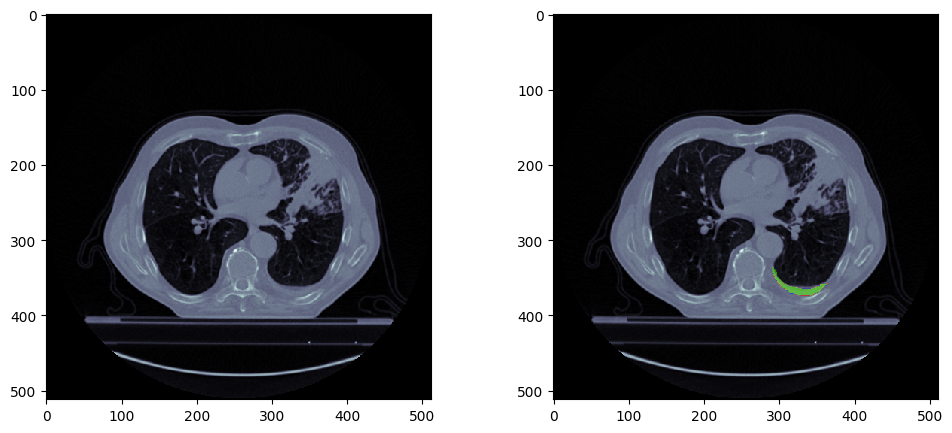

In [35]:
for record in dataset:
    parsed_record = parse_record(record)
    decoded_record = decode_record(parsed_record)
    feature, label = decoded_record
    print(feature.shape, label.shape)
    plot_overlay(feature.numpy(), label.numpy())
    break